<a href="https://colab.research.google.com/github/HyungsunSo/Final-Team1/blob/main/FinalProject_1%EC%A1%B0_%EC%86%8C%ED%98%95%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치

In [ ]:
pip install nltk

In [ ]:
pip install krwordrank

In [ ]:
!pip install openpyxl

In [ ]:
!pip install chardet

In [37]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.2 MB/s eta 0:00:00


In [52]:
import matplotlib as mpl

print("설정파일 위치: ", mpl.matplotlib_fname())


설정파일 위치:  /usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/matplotlibrc


In [53]:
  !apt-get install fonts-nanum*
  !apt-get install fontconfig
  !fc-cache -fv
  !cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/matplotlibrc
  !rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20200506-1).
fonts-nanum-coding is already the newest version (2.5-3).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fontconfig is already the newest version (2.13.1-4.2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/font

# 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import os
import io

# 소형선

## 데이터 특성 확인

In [ ]:
#인코딩 언어 확인

import chardet

with open("/content/weighted_score_above_08_translated.csv", "rb") as f:
    print(chardet.detect(f.read(50000)))  # 앞 5만 바이트 샘플 확인

In [ ]:
##ID 특성 확인
# 중복 여부만 확인

# recommendationid 중복 개수
dup_recommendationid = df['recommendationid'].duplicated().sum()
print("recommendationid 중복 개수:", dup_recommendationid)

# author_steamid 중복 개수
dup_author = df['author_steamid'].duplicated().sum()
print("author_steamid 중복 개수:", dup_author)


##실제 어떤 값이 중복되었는지 확인

# recommendationid 중복된 값들 확인
dup_recommendationid_values = df[df['recommendationid'].duplicated()]['recommendationid'].unique()
print("중복된 recommendationid 값들:", dup_recommendationid_values)

# author_steamid 중복된 값들 확인
dup_author_values = df[df['author_steamid'].duplicated()]['author_steamid'].unique()
print("중복된 author_steamid 값들:", dup_author_values)


##각 값이 몇 번씩 나왔는지 확인

# recommendationid 출현 횟수
rec_counts = df['recommendationid'].value_counts()
print(rec_counts[rec_counts > 1])  # 2번 이상 나온 것만 출력

# author_steamid 출현 횟수
author_counts = df['author_steamid'].value_counts()
print(author_counts[author_counts > 1])  # 2번 이상 나온 것만 출력


## 데이터 전처리

In [ ]:
#### 전처리 0

## 선민님 review 데이터를 영어로 번역하는 코드 들어가야 하는 위치

In [ ]:
df = pd.read_csv("/weighted_score_above_08_translated_en_ko.csv")

/tmp/ipython-input-2740304557.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/weighted_score_above_08_translated_en_ko.csv")


In [ ]:
### 전처리 1-1

df[['timestamp_created', 'timestamp_updated','author_last_played']] = df[['timestamp_created', 'timestamp_updated','author_last_played']].apply(
    pd.to_datetime, unit='s'
)

# 변환확인
#print(df)
#print(df.dtypes)
#df['timestamp_created']

print("데이터 개수:", len(df))

### 스팟파이어로 시각화 결과 코로나 시즌에 게임보유수가 가파르게 증가한게 보임

데이터 개수: 410642


In [ ]:
# 전처리1-2 5년 내 데이터

import pandas as pd
# timestamp_created 즉 리뷰 작성일자

# 1. 가장 최신 날짜 구하기
latest_date = df['timestamp_created'].max()

# 2. 5년 전 cutoff 계산
cutoff_date = latest_date - pd.DateOffset(years=5)

# 3. 필터링 (5년 이내 데이터만 남김)
df = df[df['timestamp_created'] >= cutoff_date].copy()

print("📅 최신 날짜:", latest_date)
print("⏳ 기준일(5년 전):", cutoff_date)
print("5년 이내 데이터 개수:", len(df))

📅 최신 날짜: 2023-11-03 00:38:37
⏳ 기준일(5년 전): 2018-11-03 00:38:37
5년 이내 데이터 개수: 317286


In [ ]:
#### 전처리 2

#. [(리뷰수0, 보유수0, 플레이타임0, 작성전 플레이타임0)] 컬럼
#      : 실제 플레이한 경험을 토대로 리뷰를 작성하는 유저가 분석대상이므로 전처리함.


df = df[(df['author_num_reviews'] != 0)
  & (df["author_num_games_owned"] != 0)
  & (df['author_playtime_forever'] != 0)
  & (df["author_playtime_at_review"] != 0)]

print("데이터 개수:", len(df))


데이터 개수: 188280


In [ ]:
#### 전처리 3 컬럼 삭제

# ['steam_china_location'] 컬럼 : language 컬럼이 있기 때문에 삭제가능
# 혹은 위 컬럼이 O인데 language가 schinese가 아닌 경우 확인

df = df.drop(columns=['steam_china_location'])

print("데이터 개수:", len(df))

데이터 개수: 188280


In [ ]:
df_genres = pd.read_csv("/content/appid_genres.csv")

In [ ]:
# ';' 기준으로 split 후 앞에서 5개만
# Convert the 'genres' column to string type before splitting to handle potential non-string values
df_genres = df_genres['genres'].astype(str).str.split(';').apply(lambda x: x[:5])

# 리스트 → DataFrame (index 맞추기)
df_genres = pd.DataFrame(df_genres.tolist(), index=df_genres.index)

# 컬럼명 지정
df_genres.columns = [f'genres{i+1}' for i in range(df_genres.shape[1])]

# 기존 df와 합치기 (appid 포함 유지)
df_genres = pd.concat([df_genres, genres_split], axis=1)

In [ ]:
df_genres = pd.read_csv('/appid_genres_split.csv')

In [ ]:
df_genres['multi'] = df_genres['genres'].str.contains('multi', case=False, na=False)

In [ ]:
# appid 기준으로 merge
df = pd.merge(
    df,
    df_genres[['appid', 'genres1', 'genres2', 'genres3','multi']],  # 필요한 컬럼만 가져오기
    on='appid',    # 기준 컬럼
    how='left'     # df1은 전부 유지, df2에 없으면 NaN
)

print("데이터 개수:", len(df))

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,_nllb_src,translated_en,is_outlier,genres1,genres2,genres3
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,1,0,0,1,zho_Hans,"I will not forget that this evening, the guy w...",False,Action,NaN,NaN
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,1,0,0,1,rus_Cyrl,"So after you removed the CSGO, you decided to ...",False,Action,NaN,NaN
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,1,0,0,1,zho_Hans,"I was always watching my dad play CS, and I th...",True,Action,NaN,NaN
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,0,0,0,1,rus_Cyrl,"I went to the servo, and there were some guys ...",True,Action,NaN,NaN
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,1,0,0,1,zho_Hans,He was really pushing him to play CS1.6 and th...,True,Action,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188275,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,1,0,1,0,zho_Hans,I'm looking forward to the day-to-day running ...,False,Simulation,NaN,NaN
188276,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,1,0,1,0,spa_Latn,Mola But you miss Spanish.,False,Simulation,NaN,NaN
188277,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,1,0,1,0,eng_Latn,>goes inside the store >shoots hostage >refuse...,False,Simulation,NaN,NaN
188278,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,0,1,0,0,jpn_Jpan,The story is about a protagonist who is able t...,True,Adventure,NaN,NaN


In [ ]:
import pandas as pd

# CSV 불러오기
df_free = pd.read_csv("/Appid_isfree.csv")  # 9606행, appid + is_free 있음

# appid 기준으로 merge
df = pd.merge(
    df,
    df_free[['appid', 'is_free']],  # 필요한 컬럼만 가져오기
    on='appid',    # 기준 컬럼
    how='left'     # df1은 전부 유지, df2에 없으면 NaN
)

print("데이터 개수:", len(df))

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,received_for_free,written_during_early_access,hidden_in_steam_china,_nllb_src,translated_en,is_outlier,genres1,genres2,genres3,is_free
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,0,0,1,zho_Hans,"I will not forget that this evening, the guy w...",False,Action,NaN,NaN,False
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,0,0,1,rus_Cyrl,"So after you removed the CSGO, you decided to ...",False,Action,NaN,NaN,False
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,0,0,1,zho_Hans,"I was always watching my dad play CS, and I th...",True,Action,NaN,NaN,False
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,0,0,1,rus_Cyrl,"I went to the servo, and there were some guys ...",True,Action,NaN,NaN,False
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,0,0,1,zho_Hans,He was really pushing him to play CS1.6 and th...,True,Action,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188275,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,0,1,0,zho_Hans,I'm looking forward to the day-to-day running ...,False,Simulation,NaN,NaN,NaN
188276,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,0,1,0,spa_Latn,Mola But you miss Spanish.,False,Simulation,NaN,NaN,NaN
188277,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,0,1,0,eng_Latn,>goes inside the store >shoots hostage >refuse...,False,Simulation,NaN,NaN,NaN
188278,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,1,0,0,jpn_Jpan,The story is about a protagonist who is able t...,True,Adventure,NaN,NaN,NaN


In [99]:
import pandas as pd

df_salesvolume = pd.read_csv("/content/steam_core_data - steam_core_data.csv")
df_peak = pd.read_csv("/content/all-time peak.csv")

#appid 중복되는 경우 제거
df_salesvolume = df_salesvolume.drop_duplicates(subset=['appid'])
df_peak = df_peak.drop_duplicates(subset=['appid'])

,appid,owners_min,owners_max,ccu
0,1001220,0,"20,000",1.0
1,1002100,0,"20,000",0.0
2,1001960,0,"20,000",0.0
3,1000440,0,"20,000",0.0
4,1001860,0,"20,000",1.0
...,...,...,...,...
11591,212680,NaN,NaN,NaN
11592,676090,NaN,NaN,NaN
11593,2499670,NaN,NaN,NaN
11594,896160,NaN,NaN,NaN


In [102]:
# appid 기준으로 merge
df = pd.merge(
    df,
    df_salesvolume[['appid', 'owners_min', 'owners_max', 'ccu']],  # 필요한 컬럼만 가져오기
    on='appid',    # 기준 컬럼
    how='left'     # df1은 전부 유지, df2에 없으면 NaN
)

print("데이터 개수:", len(df))

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,sale_end_utc,on_valve_event,event_start_utc,event_end_utc,sale_context,event_name,event_type,owners_min,owners_max,ccu
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,2020-12-22 19:01:33+00:00,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,2020-12-22 19:01:33+00:00,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,2020-12-22 19:01:33+00:00,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,2020-12-22 19:01:33+00:00,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,2020-12-22 19:01:33+00:00,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188268,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,2021-06-17 15:39:24+00:00,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0
188269,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,2021-06-17 15:39:24+00:00,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0
188270,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,2021-06-17 15:39:24+00:00,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0
188271,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,NaN,False,2019-06-04 00:00:00+00:00,2019-06-07 00:00:00+00:00,none,World Environment Day Sale 2019,sale,0,"20,000",0.0


In [103]:
# appid 기준으로 merge
df = pd.merge(
    df,
    df_peak[['appid', 'all-time peak']],  # 필요한 컬럼만 가져오기
    on='appid',    # 기준 컬럼
    how='left'     # df1은 전부 유지, df2에 없으면 NaN
)

# 결과 저장
print("데이터 개수:", len(df))

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,on_valve_event,event_start_utc,event_end_utc,sale_context,event_name,event_type,owners_min,owners_max,ccu,all-time peak
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0,"319,586"
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0,"319,586"
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0,"319,586"
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0,"319,586"
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,True,2023-09-25 00:00:00+00:00,2023-10-02 00:00:00+00:00,event_only,SHMUP Fest,fest,"10,000,000","20,000,000",7323.0,"319,586"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188268,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0,"3,330"
188269,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0,"3,330"
188270,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,True,2021-06-16 00:00:00+00:00,2021-06-22 00:00:00+00:00,event_only,Next Fest: June 2021,fest_next,"1,000,000","2,000,000",318.0,"3,330"
188271,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,False,2019-06-04 00:00:00+00:00,2019-06-07 00:00:00+00:00,none,World Environment Day Sale 2019,sale,0,"20,000",0.0,NaN


In [104]:
import pandas as pd

# 1. timestamp → datetime → 월 단위 변환

df['author_last_played'] = pd.to_datetime(df['author_last_played'])
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'])
df['sale_start_utc'] = pd.to_datetime(df['sale_start_utc'])
df['sale_end_utc'] = pd.to_datetime(df['sale_end_utc'])
df['event_start_utc'] = pd.to_datetime(df['event_start_utc'])
df['event_end_utc'] = pd.to_datetime(df['event_end_utc'])

df['year_month'] = df['timestamp_created'].dt.to_period('M')

# 2. 월별 × 장르 집계
monthly = (
    df.groupby(['year_month', 'genres1'])
    .size()
    .reset_index(name='count')
)

# 3. 연속 월 타임라인 만들기
all_months = pd.period_range(df['timestamp_created'].min(), df['timestamp_created'].max(), freq='M')

# 4. 장르별로 reindex 적용 → 연속성 확보
genre_list = monthly['genres1'].unique()
filled = []

for g in genre_list:
    temp = monthly[monthly['genres1'] == g].set_index('year_month')
    temp = temp.reindex(all_months, fill_value=0)
    temp['genres1'] = g
    temp = temp.reset_index().rename(columns={'index': 'year_month'})
    filled.append(temp)

monthly_filled = pd.concat(filled, ignore_index=True)

/tmp/ipython-input-2950472881.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['timestamp_created'].dt.to_period('M')


In [88]:
import numpy as np

pivot = monthly_filled.pivot(index='year_month', columns='genres1', values='count')
prop = pivot.div(pivot.sum(axis=1), axis=0)
prop_rolling = prop.rolling(3, min_periods=1).mean()
growth_3m = prop_rolling.pct_change()   # NaN 유지



In [ ]:
# 리뷰컬럼 정규식 진행

import pandas as pd
import re

# review 컬럼 기준
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # 1) 소문자 변환
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # 2) URL 제거
    text = re.sub(r"@\w+", "", text)  # 3) 멘션 제거
    text = re.sub(r"#\w+", "", text)  # 4) 해시태그 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", " ", text)  # 5) 특수문자 제거 (한글,영문,숫자만)
    text = re.sub(r"\d+", " ", text)  # 6) 숫자 제거
    text = re.sub(r"\s+", " ", text).strip()  # 7) 연속 공백 제거
    return text

# 적용
df['review'] = df['review'].apply(clean_text)
df['translated_en'] = df['translated_en'].apply(clean_text)

In [ ]:
#한글언어 깨지는지 확인
df[df['language'] == 'koreana'].head()

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,received_for_free,written_during_early_access,hidden_in_steam_china,_nllb_src,translated_en,is_outlier,genres1,genres2,genres3,is_free
259,59846635,10,Counter-Strike,76561198010940925,96,9,171023,172,150854,2023-10-24 12:38:40,...,0,0,0,NaN,플레이시간이 증명해줌,True,Action,NaN,NaN,False
338,86882676,1000360,Hellish Quart,76561198034633587,116,9,254,0,99,2022-07-09 16:01:42,...,0,1,0,NaN,김상윤이 이 게임을 보증한다,False,Action,Early Access,NaN,False
578,97834647,1003590,Tetris® Effect: Connected,76561197967923946,14506,178,402,37,48,2023-10-22 10:15:58,...,0,0,0,NaN,완성된 게임을 현대화시키는 영리한 리메이크 물론 현대화고 나발이고 긴건 필요할때 여...,True,Casual,Indie,NaN,False
618,50109195,1004240,Hentai Girl Karen,76561198084955293,142,34,29,0,9,2019-04-13 13:16:24,...,0,0,0,NaN,집중력을 높히기 위해 퍼즐게임을 구입했습니다 엄마가 와서 나머지는 나중에 마저해야겠습니다,False,Casual,Indie,RPG,False
656,79097019,1005520,Harem Girl: Alicia,76561198300270231,5164,875,135,0,135,2020-03-31 14:04:11,...,0,0,0,NaN,평화로운 음악을 들으며 알리샤가 일상복 메이드복 도복 네코미미 메탈 슈트 등을 입을...,True,Adventure,Casual,Indie,NaN


In [21]:
import pandas as pd

# ['author_playtime_forever'] 데이터 특성 확인

q005 = df['author_playtime_forever'].quantile(0.05)
q1 = df['author_playtime_forever'].quantile(0.25)
q2 = df['author_playtime_forever'].quantile(0.50)
q3 = df['author_playtime_forever'].quantile(0.75)
q095 = df['author_playtime_forever'].quantile(0.95)

mean_val = df['author_playtime_forever'].mean()
median_val = df['author_playtime_forever'].median()
var_val = df['author_playtime_forever'].var()
std_val = df['author_playtime_forever'].std()

print("📊 Quantiles:")
print(f"  5% Quantile : {q005:.2f}")
print(f" 25% Quantile : {q1:.2f}")
print(f" 50% (Median) : {q2:.2f}")
print(f" 75% Quantile : {q3:.2f}")
print(f"95% Quantile : {q095:.2f}")

print("\n📈 Summary Stats:")
print(f" Mean          : {mean_val:.2f}")
print(f" Median        : {median_val:.2f}")
print(f" Variance      : {var_val:.2f}")
print(f" Std Deviation : {std_val:.2f}")


# ['author_playtime_forever']기준 분류 컬럼 생성


def classify_user(playtime):
    if playtime < 2:
        return "own" #보유만 (0~2h 미만) 스팀환불기준
    elif playtime < 10:
        return "trial" #맛보기 (2~10h 미만)
    elif playtime < q3:
        return "normal" #일반 유저 (10h~Q3 미만)
    elif playtime < q95:
        return "heavy" #헤비 유저 (Q3~Q95 미만)
    else:
        return "core" #코어 유저 (Q95 이상)

# 새로운 컬럼 생성
df['user_groupby_playtime'] = df['author_playtime_forever'].apply(classify_user)

In [29]:
import pandas as pd

# ['author_num_games_owned'] 데이터 특성 확인
Q05 = df['author_num_games_owned'].quantile(0.05)
Q25 = df['author_num_games_owned'].quantile(0.25)
Q50 = df['author_num_games_owned'].quantile(0.50)
Q75 = df['author_num_games_owned'].quantile(0.75)
Q95 = df['author_num_games_owned'].quantile(0.95)


mean_val = df['author_playtime_forever'].mean()
median_val = df['author_playtime_forever'].median()
var_val = df['author_playtime_forever'].var()
std_val = df['author_playtime_forever'].std()

print("📊 Quantiles:")
print(f"  5% Quantile : {q005:.2f}")
print(f" 25% Quantile : {q1:.2f}")
print(f" 50% (Median) : {q2:.2f}")
print(f" 75% Quantile : {q3:.2f}")
print(f"95% Quantile : {q095:.2f}")

print("\n📈 Summary Stats:")
print(f" Mean          : {mean_val:.2f}")
print(f" Median        : {median_val:.2f}")
print(f" Variance      : {var_val:.2f}")
print(f" Std Deviation : {std_val:.2f}")


# ['author_num_games_owned']기준 분류 컬럼 생성

def classify_owner(num_games):
    if num_games < Q25:
        return "Standard Owner" #(라이트 소유자)	게임 소유에 큰 관심이 없거나, 이제 막 시작한 유저.
    elif num_games < Q50:
        return "Collector" #(일반 소유자)	평균적인 수준으로 게임을 소유하는 대다수의 유저.
    elif num_games < Q75:
        return "Seasonal Collector" #(컬렉터)	평균보다 높은 구매력을 바탕으로 꾸준히 게임을 수집하는 유저.
    elif num_games < Q95:
        return "VIP" #(베테랑 수집가)	수백 개의 게임을 보유한, 상위 계층의 구매력 높은 유저.
    else:
        return "VVIP" #(보유왕/수장가)	극소수이며, 압도적인 게임 수를 자랑하는 초고액/초고관심 유저.

# 새로운 컬럼 생성
df['user_groupby_owner'] = df['author_num_games_owned'].apply(classify_owner)

📊 Quantiles:
  5% Quantile : 21.00
 25% Quantile : 70.00
 50% (Median) : 157.00
 75% Quantile : 5439.00
95% Quantile : 1709.00

📈 Summary Stats:
 Mean          : 14914.76
 Median        : 1278.00
 Variance      : 6353362066.87
 Std Deviation : 79707.98


In [53]:
# 한글인 리뷰 보기 (깨짐 확인)
df.loc[df['language'] == 'koreana', 'translated_en'].head()

,translated_en
259,플레이시간이 증명해줌
338,김상윤이 이 게임을 보증한다
578,완성된 게임을 현대화시키는 영리한 리메이크 물론 현대화고 나발이고 긴건 필요할때 여...
618,집중력을 높히기 위해 퍼즐게임을 구입했습니다 엄마가 와서 나머지는 나중에 마저해야겠습니다
656,평화로운 음악을 들으며 알리샤가 일상복 메이드복 도복 네코미미 메탈 슈트 등을 입을...


In [ ]:
###
### 지영님 스팀 할인 데이터 합치는 코드 들어가야하는 위치

In [72]:

# 날짜 타입으로 변환할 컬럼 리스트
date_cols = [
    'author_last_played',
    'timestamp_created',
    'timestamp_updated',
    'sale_start_utc',
    'sale_end_utc',
    'event_start_utc',
    'event_end_utc'
]

# 결측치(NaN) 오류 없이 날짜 타입으로 변환
for col in date_cols:
    # pd.to_datetime() 함수 사용
    # errors='coerce': 변환할 수 없는 값(예: NaN, 유효하지 않은 문자열)은 NaT(Not a Time)로 변환합니다.
    df[col] = pd.to_datetime(df[col], errors='coerce')

﻿"﻿""recommendationid"""                        int64
appid                                           int64
game                                           object
author_steamid                                  int64
author_num_games_owned                          int64
author_num_reviews                              int64
author_playtime_forever                         int64
author_playtime_last_two_weeks                  int64
author_playtime_at_review                       int64
author_last_played                datetime64[ns, UTC]
language                                       object
review                                         object
timestamp_created                 datetime64[ns, UTC]
timestamp_updated                 datetime64[ns, UTC]
voted_up                                        int64
votes_up                                        int64
votes_funny                                     int64
weighted_vote_score                           float64
comment_count               

In [8]:
import pandas as pd
import numpy as np


dff = pd.read_csv("/content/steamspy_cache.csv", encoding = "utf-8", index_col=0)

In [12]:
# 1. 쉼표(,) 제거 및 정수형 (int)으로 변환
# 각 컬럼에 대해 쉼표를 제거하고 numeric으로 변환
df['owners_min'] = pd.to_numeric(df['owners_min'].astype(str).str.replace(',', '', regex=False), errors='coerce').astype(pd.Int64Dtype())
df['owners_max'] = pd.to_numeric(df['owners_max'].astype(str).str.replace(',', '', regex=False), errors='coerce').astype(pd.Int64Dtype())

# 'all-time peak' 컬럼도 동일하게 처리 (쉼표가 있을 수 있으므로)
df['all-time peak'] = pd.to_numeric(df['all-time peak'].astype(str).str.replace(',', '', regex=False), errors='coerce').astype(pd.Int64Dtype())


# 결과 확인 (선택 사항)
print(df[['owners_min', 'owners_max', 'all-time peak']].head())

# 최종 데이터프레임 확인
print("\n최종 데이터프레임:")
print(df.head())
print("\n최종 컬럼 타입:")
print(df.dtypes)

   owners_min  owners_max  all-time peak
0    10000000    20000000         319586
1    10000000    20000000         319586
2    10000000    20000000         319586
3    10000000    20000000         319586
4    10000000    20000000         319586

최종 데이터프레임:
   ﻿"﻿""recommendationid"""  appid            game     author_steamid  \
0                 147449116     10  Counter-Strike  76561199183984450   
1                 147374264     10  Counter-Strike  76561198099573060   
2                 147357703     10  Counter-Strike  76561199080026894   
3                 147345102     10  Counter-Strike  76561198068970227   
4                 147284743     10  Counter-Strike  76561199137893460   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                      51                  12                     2548   
1                     226                  13                     2369   
2                     118                  23                    13501   
3      

In [13]:
# appid 기준으로 merge
dff.reset_index(inplace=True)
df = pd.merge(
    df,
    dff[['appid', 'price']],  # 필요한 컬럼만 가져오기
    on='appid',    # 기준 컬럼
    how='left'     # df1은 전부 유지, df2에 없으면 NaN
)

# 결과 저장
display(df)

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,event_name,event_type,owners_min,owners_max,ccu,all-time peak,year_month,user_groupby_playtime,user_groupby_owner,price
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,SHMUP Fest,fest,10000000,20000000,7323.0,319586,2023-10,normal,Standard Owner,999.0
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,SHMUP Fest,fest,10000000,20000000,7323.0,319586,2023-09,normal,Seasonal Collector,999.0
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,SHMUP Fest,fest,10000000,20000000,7323.0,319586,2023-09,heavy,Collector,999.0
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,SHMUP Fest,fest,10000000,20000000,7323.0,319586,2023-09,heavy,Standard Owner,999.0
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,SHMUP Fest,fest,10000000,20000000,7323.0,319586,2023-09,normal,Standard Owner,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188268,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,Next Fest: June 2021,fest_next,1000000,2000000,318.0,3330,2021-06,normal,Collector,1019.0
188269,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,Next Fest: June 2021,fest_next,1000000,2000000,318.0,3330,2021-06,normal,Seasonal Collector,1019.0
188270,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,Next Fest: June 2021,fest_next,1000000,2000000,318.0,3330,2021-06,normal,VIP,1019.0
188271,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,World Environment Day Sale 2019,sale,0,20000,0.0,<NA>,2019-06,normal,VIP,749.0


In [14]:
# 1. 'rev_min' 컬럼 생성: owners_min * price
# Pandas는 한 Series(컬럼)에 다른 Series를 곱할 때 인덱스를 맞춰서 자동으로 계산합니다.
df['rev_min'] = df['owners_min'] * df['price']

# 2. 'rev_max' 컬럼 생성: owners_max * price
df['rev_max'] = df['owners_max'] * df['price']

# 결과 확인
print("최종 데이터프레임:")
print(df)
print("\n최종 컬럼 타입:")
print(df.dtypes)

최종 데이터프레임:
        ﻿"﻿""recommendationid"""   appid  \
0                      147449116      10   
1                      147374264      10   
2                      147357703      10   
3                      147345102      10   
4                      147284743      10   
...                          ...     ...   
188268                  93916019  997010   
188269                  93914992  997010   
188270                  93911996  997010   
188271                  51109633  997060   
188272                  48814832  997180   

                                         game     author_steamid  \
0                              Counter-Strike  76561199183984450   
1                              Counter-Strike  76561198099573060   
2                              Counter-Strike  76561199080026894   
3                              Counter-Strike  76561198068970227   
4                              Counter-Strike  76561199137893460   
...                                       ...       

In [16]:
# owners_mid 컬럼 생성
df['owners_mid'] = (df['owners_min'] + df['owners_max']) / 2

# rev_mid 컬럼 생성 (중간값 예상 매출액)
df['rev_mid'] = df['owners_mid'] * df['price']

print("\n중간값 컬럼 추가 결과:")
print(df)


중간값 컬럼 추가 결과:
        ﻿"﻿""recommendationid"""   appid  \
0                      147449116      10   
1                      147374264      10   
2                      147357703      10   
3                      147345102      10   
4                      147284743      10   
...                          ...     ...   
188268                  93916019  997010   
188269                  93914992  997010   
188270                  93911996  997010   
188271                  51109633  997060   
188272                  48814832  997180   

                                         game     author_steamid  \
0                              Counter-Strike  76561199183984450   
1                              Counter-Strike  76561198099573060   
2                              Counter-Strike  76561199080026894   
3                              Counter-Strike  76561198068970227   
4                              Counter-Strike  76561199137893460   
...                                       ...   

## 전처리 완료 후 컬럼 순서를 카테고리별로 정렬

In [23]:
df = df.drop(columns=['ts'])

In [29]:

# 1. 원하는 순서의 전체 컬럼 리스트 정의 (요청하신 순서 그대로)
TARGET_ORDER = [
    '\ufeff"\ufeff""recommendationid"""', 'appid', 'game', 'author_steamid', 'author_num_games_owned',
    'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks',
    'author_playtime_at_review', 'author_last_played',

    # 2. 다른 컬럼 순서 (중간)
    'user_groupby_owner', 'user_groupby_playtime', 'language', 'review', 'translated_en',
    '_nllb_src', 'timestamp_created', 'timestamp_updated', 'year_month', 'ts',
    'voted_up', 'votes_up', 'votes_funny', 'comment_count', 'steam_purchase',
    'written_during_early_access',  'received_for_free', 'hidden_in_steam_china',
    'weighted_vote_score', 'multi', 'genres1', 'genres2', 'genres3', 'is_free', 'on_game_sale',
    'discount_max', 'sale_start_utc', 'sale_end_utc', 'on_valve_event', 'event_start_utc',
    'event_end_utc', 'sale_context', 'event_name', 'event_type', 'all-time peak',

    # 3. 분석 컬럼 순서 (맨 뒤)
    'ccu', 'owners_min', 'owners_mid', 'owners_max', 'price', 'rev_min', 'rev_mid', 'rev_max'
]

# 2. 현재 데이터프레임에 존재하는 모든 컬럼 목록 (원본 유지)
ALL_CURRENT_COLS = df.columns.tolist()

# 3. 누락될 수 있는 컬럼 확인 및 최종 순서 생성
# TARGET_ORDER에 포함된 컬럼 중 실제로 존재하는 컬럼만 선택합니다.
existing_cols_in_order = [col for col in TARGET_ORDER if col in ALL_CURRENT_COLS]

# TARGET_ORDER에 없지만 데이터프레임에는 존재하는 "남은 컬럼"을 확인합니다.
# 이 컬럼들은 재배열 리스트의 맨 마지막에 추가하여 누락되지 않도록 합니다.
remaining_cols = [col for col in ALL_CURRENT_COLS if col not in TARGET_ORDER]

# 최종 순서: [요청 순서에 맞게 정리된 컬럼] + [요청 순서에 누락된 컬럼]
final_column_order = existing_cols_in_order + remaining_cols

# 4. 데이터프레임에 새로운 컬럼 순서 적용
df = df[final_column_order]

# 5. 결과 확인
print("재배열 후 컬럼 개수:", len(df.columns))
print("재배열 후 컬럼 순서:")
print(df.columns.tolist())

재배열 후 컬럼 개수: 52
재배열 후 컬럼 순서:
['\ufeff"\ufeff""recommendationid"""', 'appid', 'game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'user_groupby_owner', 'user_groupby_playtime', 'language', 'review', 'translated_en', '_nllb_src', 'timestamp_created', 'timestamp_updated', 'year_month', 'voted_up', 'votes_up', 'votes_funny', 'comment_count', 'steam_purchase', 'written_during_early_access', 'received_for_free', 'hidden_in_steam_china', 'weighted_vote_score', 'multi', 'genres1', 'genres2', 'genres3', 'is_free', 'on_game_sale', 'discount_max', 'sale_start_utc', 'sale_end_utc', 'on_valve_event', 'event_start_utc', 'event_end_utc', 'sale_context', 'event_name', 'event_type', 'all-time peak', 'ccu', 'owners_min', 'owners_mid', 'owners_max', 'price', 'rev_min', 'rev_mid', 'rev_max']


In [32]:
##price 컬럼에서 이유모르게 소수점 사라져서 추가한 코드

# 1. 'price' 컬럼 값을 100으로 나누어 업데이트
df['price'] = df['price'] / 100

# 2. 'rev_min' 컬럼 값을 100으로 나누어 업데이트
df['rev_min'] = df['rev_min'] / 100
df['rev_mid'] = df['rev_mid'] / 100
df['rev_max'] = df['rev_max'] / 100

## 전처리 완료 후 파일 저장

In [36]:
# 저장될 파일 이름을 지정합니다.
output_file_name = 'S-team_250930-final.csv'

# to_csv() 함수를 사용하여 DataFrame을 CSV 파일로 저장합니다.
# index=False 옵션은 DataFrame의 인덱스가 파일에 별도의 열로 저장되는 것을 방지합니다.
df.to_csv(output_file_name, encoding = "utf-8", index=False)

print(f"'{output_file_name}' 파일으로 성공적으로 저장되었습니다.")
print("코랩 왼쪽 사이드바 '파일' 탭에서 저장된 파일을 확인하고 다운로드할 수 있습니다.")

'S-team_250930-final.csv' 파일으로 성공적으로 저장되었습니다.
코랩 왼쪽 사이드바 '파일' 탭에서 저장된 파일을 확인하고 다운로드할 수 있습니다.


# 가설

머신러닝 프로젝트 통합 코드


0단계: 라이브러리 로드 및 가상 데이터 준비

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('/content/S-team_250930-final.csv')

In [4]:
df

,"﻿""﻿""""recommendationid""""""",appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,event_type,all-time peak,ccu,owners_min,owners_mid,owners_max,price,rev_min,rev_mid,rev_max
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,2023-10-03 03:57:37,...,fest,319586.0,7323.0,10000000.0,15000000.0,20000000.0,9.99,99900000.0,149850000.0,199800000.0
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,2023-09-30 17:55:55,...,fest,319586.0,7323.0,10000000.0,15000000.0,20000000.0,9.99,99900000.0,149850000.0,199800000.0
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,2023-10-18 12:05:34,...,fest,319586.0,7323.0,10000000.0,15000000.0,20000000.0,9.99,99900000.0,149850000.0,199800000.0
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,2023-10-25 19:10:11,...,fest,319586.0,7323.0,10000000.0,15000000.0,20000000.0,9.99,99900000.0,149850000.0,199800000.0
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,2023-10-20 14:09:51,...,fest,319586.0,7323.0,10000000.0,15000000.0,20000000.0,9.99,99900000.0,149850000.0,199800000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188268,93916019,997010,Police Simulator: Patrol Officers,76561198180957697,109,7,2206,0,60,2023-08-25 04:00:02,...,fest_next,3330.0,318.0,1000000.0,1500000.0,2000000.0,10.19,10190000.0,15285000.0,20380000.0
188269,93914992,997010,Police Simulator: Patrol Officers,76561198286564086,181,31,2120,0,184,2023-08-06 19:44:00,...,fest_next,3330.0,318.0,1000000.0,1500000.0,2000000.0,10.19,10190000.0,15285000.0,20380000.0
188270,93911996,997010,Police Simulator: Patrol Officers,76561198217879469,413,64,476,0,21,2021-06-22 15:02:32,...,fest_next,3330.0,318.0,1000000.0,1500000.0,2000000.0,10.19,10190000.0,15285000.0,20380000.0
188271,51109633,997060,Kotodama: The 7 Mysteries of Fujisawa,76561198091884692,1588,32,835,0,835,2019-06-06 23:42:56,...,sale,NaN,0.0,0.0,10000.0,20000.0,7.49,0.0,74900.0,149800.0


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==============================================================================
# 1. 데이터 전처리 및 Feature Engineering
# ==============================================================================

# 1-1. 컬럼명 변경 (실제 데이터 컬럼명에 맞게 수정)
# 'appid'와 '게임 보유자수 추정치'를 분석에 사용하기 쉬운 이름으로 변경합니다.
# **주의:** 실제 df에 해당 컬럼이 있는지 확인하세요.
df = df.rename(columns={
    'appid': 'Game_ID',
    'owners_mid': 'Owners_Estimated'
})

# 1-2. 리뷰당 개별 활성도 점수 계산
# 댓글(comment_count)에 10의 가중치를 부여하여 소통의 중요성을 강조합니다.
df['Review_Activity_Score'] = (
    df['weighted_vote_score'] +
    df['votes_up'] +
    df['votes_funny'] +
    df['comment_count'] * 10
)

# 1-3. Weighted Quality Index 계산 (Row-wise calculation before aggregation)
# 가중치: comment_count(0.5) > votes_up(0.3) > weighted_vote_score(0.2)
# Calculate this score for each review first
df['Weighted_Quality_Score'] = (
    df['comment_count'] * 0.5 +
    df['votes_up'] * 0.3 +
    df['weighted_vote_score'] * 0.2
)


# 1-4. 게임 단위로 데이터 집계 (Aggregation)
df_game = df.groupby('Game_ID').agg(
    # Y 변수 (게임 보유자수 추정치)
    Owners_Estimated=('Owners_Estimated', 'first'),
    Total_Reviews=('Game_ID', 'size'),

    # ----------------------------------------------------------------------
    # X1: 게임 규모 보정 지표 (평균 활성도)
    # ----------------------------------------------------------------------
    X1_Avg_Activity=('Review_Activity_Score', 'mean'),

    # ----------------------------------------------------------------------
    # X2: 품질 집중 지표 (Weighted Quality Index) - Now taking the mean of the pre-calculated score
    # ----------------------------------------------------------------------
    X2_Weighted_Quality=('Weighted_Quality_Score', 'mean')

).reset_index()


# 분석에 사용할 데이터프레임 최종 정리 및 Y 변수 로그 변환 (분포 정규화를 통해 회귀 분석 성능 향상)
df_analysis = df_game[['Game_ID', 'Owners_Estimated', 'X1_Avg_Activity', 'X2_Weighted_Quality']].copy()
df_analysis['Y_log'] = np.log1p(df_analysis['Owners_Estimated']) # log1p는 log(1+x)로, 0일 때도 처리가능

print("--- 1단계: 집계된 데이터셋 (게임 단위, 상위 5개) ---")
print(df_analysis.head())

--- 1단계: 집계된 데이터셋 (게임 단위, 상위 5개) ---
   Game_ID  Owners_Estimated  X1_Avg_Activity  X2_Weighted_Quality      Y_log
0       10        15000000.0       203.911145            49.051512  16.523561
1       20         1500000.0       162.967288            34.139611  14.220976
2       30         7500000.0       138.893399            35.512013  15.830414
3       40         7500000.0        74.828164            17.245633  15.830414
4       50         3500000.0       102.579884            19.215977  15.068274


2단계: 탐색적 분석 및 통계적 가설 검증


두 지표(X1, X2)와 게임 성공 지표(Y) 간의 통계적 관계를 검증합니다.


--- 2-1: 상관 계수 (Pearson's r) ---
                        Y_log  X1_Avg_Activity  X2_Weighted_Quality
Y_log                1.000000         0.110265             0.125396
X1_Avg_Activity      0.110265         1.000000             0.956936
X2_Weighted_Quality  0.125396         0.956936             1.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

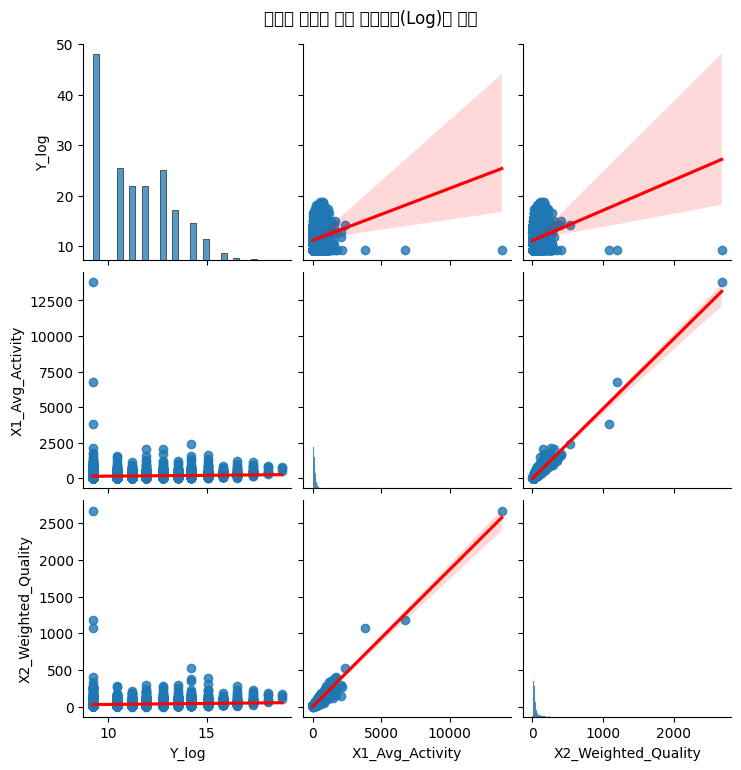


--- 2-3: 회귀 분석 요약 (X1 - 평균 활성도 지표) ---
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.1574      0.023    490.183      0.000      11.113      11.202
X1_Avg_Activity     0.0010   8.64e-05     11.930      0.000       0.001       0.001
R-squared (X1): 0.0122

--- 2-3: 회귀 분석 요약 (X2 - 가중치 기반 품질 지표) ---
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.1179      0.023    473.622      0.000      11.072      11.164
X2_Weighted_Quality     0.0060      0.000     13.592      0.000       0.005       0.007
R-squared (X2): 0.0157


In [7]:
# ==============================================================================
# 2. 통계적 가설 검증 및 시각화
# ==============================================================================

# 2-1. 상관 분석
correlation_matrix = df_analysis[['Y_log', 'X1_Avg_Activity', 'X2_Weighted_Quality']].corr()
print("\n--- 2-1: 상관 계수 (Pearson's r) ---")
print(correlation_matrix)

# 2-2. 시각화 (산점도)
sns.pairplot(df_analysis,
             vars=['Y_log', 'X1_Avg_Activity', 'X2_Weighted_Quality'],
             kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('활성도 지표와 게임 보유자수(Log)의 관계', y=1.02)
plt.show()

# 2-3. 단순 회귀 분석 (통계적 유의성 검증)

# 모델 1: X1 지표 사용 (평균 활성도)
X1 = sm.add_constant(df_analysis['X1_Avg_Activity'])
model1 = sm.OLS(df_analysis['Y_log'], X1, missing='drop').fit()

# 모델 2: X2 지표 사용 (가중치 기반 품질)
X2 = sm.add_constant(df_analysis['X2_Weighted_Quality'])
model2 = sm.OLS(df_analysis['Y_log'], X2, missing='drop').fit()

print("\n--- 2-3: 회귀 분석 요약 (X1 - 평균 활성도 지표) ---")
print(model1.summary().tables[1])
print(f"R-squared (X1): {model1.rsquared:.4f}")

print("\n--- 2-3: 회귀 분석 요약 (X2 - 가중치 기반 품질 지표) ---")
print(model2.summary().tables[1])
print(f"R-squared (X2): {model2.rsquared:.4f}")

3단계: 머신러닝 예측 모델 구축 (Random Forest Regressor)


통계적 유의성이 확인되었다면, 이제 예측 성능을 최적화하기 위해 머신러닝 모델

(회귀 모델 추천)을 사용합니다.


--- 3-1: Random Forest 예측 모델 평가 ---
Mean Squared Error (MSE): 3.6477
Root Mean Squared Error (RMSE): 1.9099
R-squared (ML Model): -0.0067

--- 3-2: 변수 중요도 (Feature Importance) ---
X2_Weighted_Quality    0.518703
X1_Avg_Activity        0.481297
dtype: float64


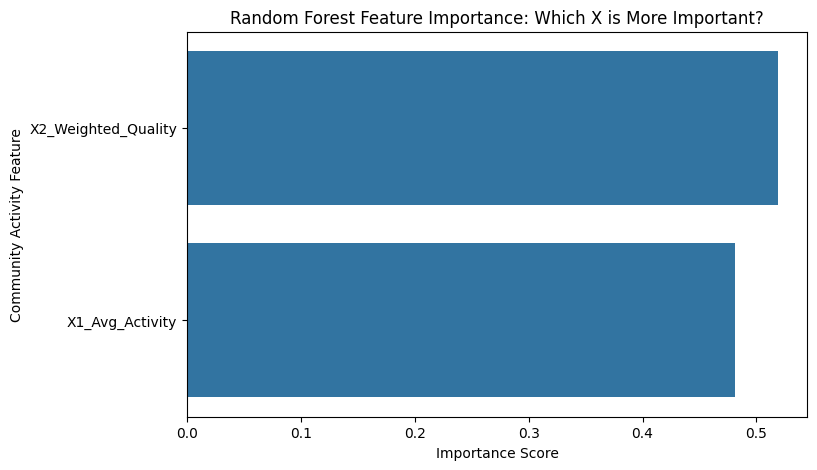

In [9]:
# ==============================================================================
# 3. 머신러닝 예측 모델 구축 (Random Forest Regressor)
# ==============================================================================

# 독립 변수 (X)와 종속 변수 (Y) 정의
X = df_analysis[['X1_Avg_Activity', 'X2_Weighted_Quality']] # 두 지표 모두 사용
Y = df_analysis['Y_log'] # 로그 변환된 보유자수

# Drop rows where the target variable (Y_log) is NaN
# This is necessary because most ML models cannot handle NaN in the target variable
df_analysis_cleaned = df_analysis.dropna(subset=['Y_log']).copy()

X_cleaned = df_analysis_cleaned[['X1_Avg_Activity', 'X2_Weighted_Quality']]
Y_cleaned = df_analysis_cleaned['Y_log']


# 데이터 분할 (훈련 세트 80%, 테스트 세트 20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_cleaned, Y_cleaned, test_size=0.2, random_state=42)

# 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)

# 예측 및 모델 평가
Y_pred = rf_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("\n--- 3-1: Random Forest 예측 모델 평가 ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (ML Model): {r2:.4f}")

# 변수 중요도 (Feature Importance) 확인
feature_importance = pd.Series(rf_model.feature_importances_, index=X_cleaned.columns).sort_values(ascending=False)

print("\n--- 3-2: 변수 중요도 (Feature Importance) ---")
print(feature_importance)

# 변수 중요도 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Random Forest Feature Importance: Which X is More Important?')
plt.xlabel('Importance Score')
plt.ylabel('Community Activity Feature')
plt.show()

In [11]:
# ==============================================================================
# 1. 데이터 전처리 및 Feature Engineering (추가된 부분)
# ==============================================================================

# 기존 df_game에 새로운 컬럼들을 병합하기 위해 다시 집계합니다.
# 주의: genres1, multi, is_free, price는 게임별로 고유한 값이므로 'first'로 집계합니다.
df_game_new = df.groupby('Game_ID').agg(
    Owners_Estimated=('Owners_Estimated', 'first'),
    Total_Reviews=('Game_ID', 'size'),
    X1_Avg_Activity_new=('Review_Activity_Score', 'mean'), # Renamed to avoid conflict

    # 추가 변수 집계
    genres1=('genres1', 'first'),
    multi=('multi', 'first'),
    is_free=('is_free', 'first'),
    price=('price', 'first')
).reset_index()

# 기존 df_analysis의 X1, X2 지표를 df_game_new와 병합 (Game_ID 기준)
# Ensure df_analysis contains the correct Game_ID and Y_log
df_analysis_subset = df_analysis[['Game_ID', 'X1_Avg_Activity', 'X2_Weighted_Quality', 'Y_log']].copy()
df_merged = pd.merge(df_game_new, df_analysis_subset, on='Game_ID', how='inner', suffixes=('_new', '_old'))

# 범주형 변수 (genres1) 원-핫 인코딩
# 모델이 장르를 숫자 형태로 이해할 수 있도록 변환합니다.
df_encoded = pd.get_dummies(df_merged, columns=['genres1'], prefix='Genre', drop_first=True)

# 최종 분석 데이터셋
# X 변수와 Y 변수 정리
FINAL_FEATURES = ['X1_Avg_Activity_old', 'X2_Weighted_Quality_old', # Use suffixed names
                  'multi', 'is_free', 'price'] + [col for col in df_encoded.columns if col.startswith('Genre_')]

# Ensure all FINAL_FEATURES exist in df_encoded before dropping NaNs
existing_final_features = [col for col in FINAL_FEATURES if col in df_encoded.columns]

df_final = df_encoded.dropna(subset=['Y_log'] + existing_final_features).copy() # 결측치 제거

In [16]:
# ==============================================================================
# 2. 다중 회귀 분석 (Statsmodels 사용)
# ==============================================================================

# Print columns of df_final for debugging
print("Columns of df_final:", df_final.columns.tolist())

# X 변수 준비 (활성도 지표 + 게임 특성)
# Ensure all features in FINAL_FEATURES are in df_final before selecting
existing_X_features = [col for col in FINAL_FEATURES if col in df_final.columns]
X_multi = df_final[existing_X_features].copy() # Use .copy() to avoid SettingWithCopyWarning
Y_log = df_final['Y_log'].copy() # Use .copy()

# Explicitly convert boolean and object columns to numeric (0 or 1)
for col in ['multi', 'is_free'] + [col for col in X_multi.columns if col.startswith('Genre_')]:
    if col in X_multi.columns:
        X_multi[col] = X_multi[col].astype(int)

# Ensure price is numeric
if 'price' in X_multi.columns:
    X_multi['price'] = pd.to_numeric(X_multi['price'], errors='coerce')
    # Handle NaNs in price if any were coerced
    X_multi['price'].fillna(X_multi['price'].median(), inplace=True) # Or use mean, or drop rows

# Check if the expected features are actually selected and their dtypes
print("Selected X_multi columns and dtypes:", X_multi.dtypes)

# Drop rows with NaNs in X_multi or Y_log after conversions/imputation
# This is crucial for statsmodels if NaNs were introduced or not handled by imputation
data_for_ols = pd.concat([X_multi, Y_log], axis=1)
print("Number of rows before dropping NaNs:", len(data_for_ols))
data_for_ols.dropna(inplace=True)
print("Number of rows after dropping NaNs:", len(data_for_ols))


X_multi_cleaned = data_for_ols.drop('Y_log', axis=1)
Y_log_cleaned = data_for_ols['Y_log']

# Identify and remove constant columns (zero variance)
constant_columns = X_multi_cleaned.columns[X_multi_cleaned.var() == 0]
if len(constant_columns) > 0:
    print(f"Dropping constant columns: {list(constant_columns)}")
    X_multi_cleaned = X_multi_cleaned.drop(columns=constant_columns)


# 상수항 추가
X_multi_cleaned = sm.add_constant(X_multi_cleaned)

# Check the dimensions before fitting
print("Shape of X_multi_cleaned:", X_multi_cleaned.shape)
print("Shape of Y_log_cleaned:", Y_log_cleaned.shape)


# 다중 회귀 모델 학습
model_multi = sm.OLS(Y_log_cleaned, X_multi_cleaned).fit()

print("\n--- 2. 다중 회귀 분석 결과 (새로운 변수 포함) ---")
print(model_multi.summary())
print(f"새 모델의 R-squared: {model_multi.rsquared:.4f}")

# 해석 팁:
# 1. 'R-squared'가 이전(-0.0067)보다 훨씬 높아졌는지(0.3 이상 등) 확인하세요.
# 2. 'P>|t|' 컬 컬럼에서 is_free, price, multi, Genre_... 등이 0.05 미만인지 확인하세요.
# 3. X1, X2 지표의 P>|t| 값이 0.05 미만으로 변했는지 확인하세요.

Columns of df_final: ['Game_ID', 'Owners_Estimated', 'Total_Reviews', 'X1_Avg_Activity_new', 'multi', 'is_free', 'price', 'X1_Avg_Activity', 'X2_Weighted_Quality', 'Y_log', 'Genre_Action', 'Genre_Adventure', 'Genre_Animation & Modeling', 'Genre_Audio Production', 'Genre_Casual', 'Genre_Design & Illustration', 'Genre_Documentary', 'Genre_Early Access', 'Genre_Education', 'Genre_Episodic', 'Genre_Free To Play', 'Genre_Game Development', 'Genre_Gore', 'Genre_Indie', 'Genre_Massively Multiplayer', 'Genre_Movie', 'Genre_Nudity', 'Genre_RPG', 'Genre_Racing', 'Genre_Sexual Content', 'Genre_Simulation', 'Genre_Software Training', 'Genre_Sports', 'Genre_Strategy', 'Genre_Utilities', 'Genre_Video Production', 'Genre_Violent', 'Genre_Web Publishing']
Selected X_multi columns and dtypes: multi                            int64
is_free                          int64
price                          float64
Genre_Action                     int64
Genre_Adventure                  int64
Genre_Animation & 

/tmp/ipython-input-974447313.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_multi['price'].fillna(X_multi['price'].median(), inplace=True) # Or use mean, or drop rows



--- 3-1: Random Forest 예측 모델 평가 (새 변수 포함) ---
R-squared (ML Model, New Features): 0.1684
Root Mean Squared Error (RMSE): 1.7471

--- 3-2: 변수 중요도 (Feature Importance) ---
price                         0.649807
Genre_Action                  0.088465
Genre_Casual                  0.048471
Genre_Adventure               0.043357
multi                         0.036245
Genre_Strategy                0.028745
is_free                       0.023783
Genre_Simulation              0.018705
Genre_Indie                   0.017439
Genre_Animation & Modeling    0.013576
dtype: float64


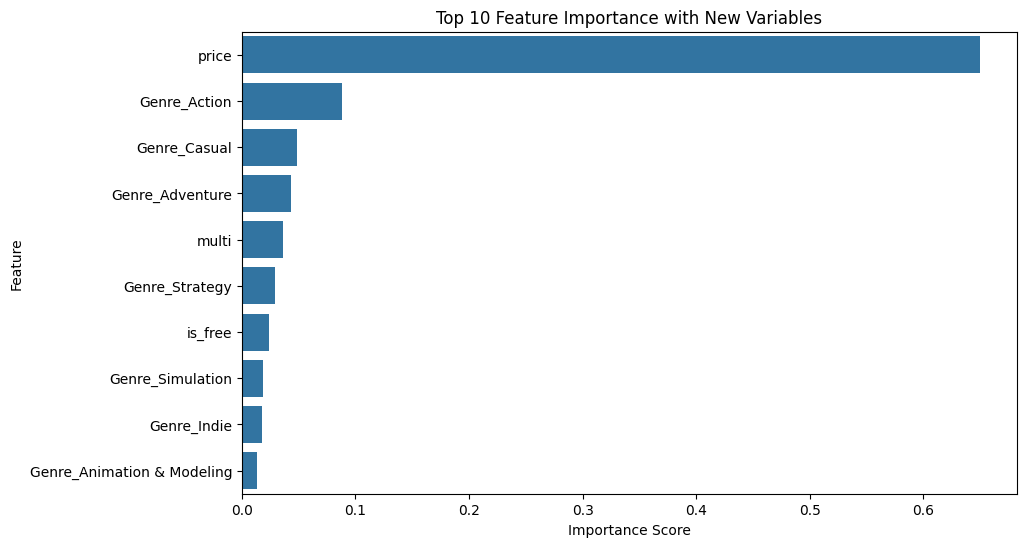

In [18]:
# ==============================================================================
# 3. 머신러닝 예측 모델 구축 및 중요度 분석
# ==============================================================================

# 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X_multi, Y_log, test_size=0.2, random_state=42)

# 모델 정의 및 학습
rf_model_new = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
rf_model_new.fit(X_train, Y_train)

# 예측 및 모델 평가
Y_pred = rf_model_new.predict(X_test)
r2_new = r2_score(Y_test, Y_pred)
rmse_new = np.sqrt(mean_squared_error(Y_test, Y_pred))

print("\n--- 3-1: Random Forest 예측 모델 평가 (새 변수 포함) ---")
print(f"R-squared (ML Model, New Features): {r2_new:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_new:.4f}")

# 변수 중요도 (Feature Importance) 확인
feature_importance = pd.Series(rf_model_new.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\n--- 3-2: 변수 중요도 (Feature Importance) ---")
print(feature_importance.head(10)) # 상위 10개만 출력

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(10).values, y=feature_importance.head(10).index)
plt.title('Top 10 Feature Importance with New Variables')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#깃헙커밋

In [ ]:
!git config --global user.name "HyungsunSo"
!git config --global user.email "hyungsun.sc@gmail.com"

#처음 클론
!git clone https://github.com/YourGitHubUsername/your-repo.git
%cd your-repo

#파일 수정/추가 후
!git add .
!git commit -m "코랩에서 커밋"
!git push https://github.com/YourGitHubUsername/your-repo.git main